# Resampling Methods

Topics covered-

* Cross-Validation
  * The Validation Set Approach
  * Leave-One-Out Cross-Validation 
  * k-FoldCross-Validation
* TheBootstrap

**Following is the summary of concepts along with data and python code-**


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import random

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

_______

**Resampling methods** involve repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about the fitted model.

Two of the most commonly used resampling methods, *cross-validation* and the *bootstrap*.

### Cross-Validation (CV)

CV is used to estimate the error rate with a given model on test data, in order to evaluate its performance (model assessment), or to select the appropriate level of flexibility (model selection). 

There are multiple methods to do this, we will take one at a time.

1. **The Validation Set Approach**

Here we randomly divide the available set of samples into two parts: a training set and a validation or hold-out set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation-set error provides an estimate of the test error. This is typically assessed using MSE in the case of a quantitative response and misclassification rate in the case of a qualitative (discrete) response.

This approach has several drawbacks:
• the validation estimate of the test error can be highly variable.
• only a subset of the observations – those that are included in the training set rather than in the
validation set – are used to fit the model.
• the validation set error may tend to overestimate the test error for the model fit on the entire data set.

In [2]:
## Lets this approach on automobile data
Auto = pd.read_csv('../data/Auto.csv', header=0, na_values='?')
Auto = Auto.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


In [3]:
## Create an array of size equal to rows in Auto data with 50% of values being true or false at random
np.random.seed(1)
train = np.random.choice(Auto.shape[0], int(Auto.shape[0]/2), replace=False)
select = np.in1d(range(Auto.shape[0]), train)

In [6]:
import statsmodels.formula.api as smf
lm = smf.ols('mpg~horsepower', data = Auto[select]).fit()
#print(lm.summary())
preds = lm.predict(Auto)
square_error = (Auto['mpg'] - preds)**2
print('--------Test Error for 1st order--------')
print(np.mean(square_error[~select]))

--------Test Error for 1st order--------
23.361902892587224


In [5]:
lm2 = smf.ols ('mpg~horsepower + I(horsepower ** 2.0)', data = Auto[select]).fit()
preds = lm2.predict(Auto)
square_error = (Auto['mpg'] - preds)**2
print('--------Test Error for 2nd order--------')
print(square_error[~select].mean())

--------Test Error for 2nd order--------
20.252690858350043


**2. Leave-One-Out Cross-Validation**

LOOCV involves splitting the set of observations into two parts. However, instead of creating two subsets of comparable size, a single observation (x1,y1) is used for the validation set, and the remaining observations {(x2, y2), . . . , (xn, yn)} make up the training set.

The statistical learning method is fit on the n − 1 training observations, and a prediction yˆ is made for the excluded single observation, using its value x1. 

We can repeat the procedure by selecting (x2,y2) for the validation data, training the statistical learning procedure on the n − 1 observations {(x ,y ),(x ,y ),...,(x ,y )}, and computing MSE. Repeating this approach n times produces n squared errors, MSE1,..., MSEn. 

The LOOCV estimate for the test MSE is the average of these n test error estimates:

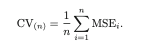

In [8]:
x = pd.DataFrame(Auto.horsepower)
y = Auto.mpg

model = LinearRegression()
model.fit(x, y)
print(model.intercept_)
print(model.coef_)

39.93586102117047
[-0.15784473]


In [9]:
k_fold = KFold(n_splits=x.shape[0]) # loo use folds equal to # of observations # Cool stuff
test = cross_val_score(model, x, y, cv=k_fold,  scoring = 'neg_mean_squared_error', n_jobs=-1)
print(np.mean(-test))

24.231513517929226


In [10]:
A = []
for porder in range(1, 6):
    model = Pipeline([('poly', PolynomialFeatures(degree=porder)), ('linear', LinearRegression())])
    k_fold = KFold(n_splits=x.shape[0]) # loo use folds equal to # of observations
    test = cross_val_score(model, x, y, cv=k_fold,  scoring = 'neg_mean_squared_error', n_jobs=-1)
    A.append(np.mean(-test))
print(A)

[24.231513517929226, 19.248213124489745, 19.33498406411498, 19.424430307079398, 19.033198669299846]


**3. k-Fold Cross-Validation**

K-fold CV is exactly like LOOCV, the only difference is that in k-fold, the number of splits are not equal to number of observations (n) in the data, like it's in LOOCV. It could be any number,k, just should be less than n. 

This approach involves randomly dividing the set of observations into k groups, or folds, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining k − 1 folds. The mean squared error, MSE1, is then computed on the observations in the held-out fold. This procedure is repeated k times; each time, a different group of observations is treated as a validation set. This process results in k estimates of the test error, MSE1, MSE2, . . . , MSEk. The k-fold CV estimate is computed by averaging these values,

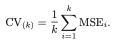

In [12]:
## Continuing on same data, with n_splits = 10. 

## You will notice computational speed to be way faster

np.random.seed(2)
A = []
for porder in range(1, 11):
    model = Pipeline([('poly', PolynomialFeatures(degree=porder)), ('linear', LinearRegression())])
    k_fold = KFold(n_splits=10) 
    test = cross_val_score(model, x, y, cv = k_fold,  scoring = 'neg_mean_squared_error', n_jobs = -1)
    A.append(np.mean(-test))    
print(A)

[27.439933652339864, 21.235840055801567, 21.336606183382038, 21.353886969306874, 20.905558736691837, 20.780544653507675, 20.952970598113758, 21.077108146457544, 21.035590598116325, 20.978001582517084]


### The Bootstrap

Bootstrap is ressampling technique. Here we obtain distinct data sets by repeatedly sampling observations from the original data set with few replacement. As a result some observation may appear more than once in a given bootstrap data set and some not at all.
The bootstrap method can be used to estimate statistic metrics on sample data when data size is too big. This is done by repeatedly taking small samples, calculating the statistic, and taking the average of the calculated statistics. 

In more complex data situations, figuring out the appropriate way to generate bootstrap samples can
require some thought. For example, if the data is a time series, we can’t simply sample the observations with
replacement. We can instead create blocks of consecutive observations, and sample those with replacements.
Then we paste together sampled blocks to obtain a bootstrap data set.

Good resources on bootstrap- https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/